In [178]:
from pymongo import MongoClient
import pprint
import pandas as pd
# Requests sends and recieves HTTP requests.
import requests
import json
import time
from scipy import stats
import numpy as np
#import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sm
plt.style.use('ggplot')

import seaborn as sns

In [67]:
import matplotlib.pyplot as plt

In [68]:
client = MongoClient('localhost', 27017)
results = client['results']
runners = results['indiv']
new = client['new_db']
indiv = new['individual']

## Data Import and Cleaning

The `runners` collection includes all of the individual race results.  The below prints the collections in my results  

In [70]:
print('There are {} results in the list'.format(len(list(runners.find()))))

There are 27438 results in the list


I converted the collection to a dataframe and converted the finish time, originally in an HH:MM:SS string format to a new column in seconds.  The head, tail, and info show the expected results, with nice clean, consistent data for runners across all age groups.

In [71]:
### Create dataframe from indiv results collection, converts time to seconds. The head shows the expected results.
df = pd.DataFrame(list(runners.find()))
df.head()
df['Time(sec)'] = pd.to_timedelta(df['time']).astype('timedelta64[s]').astype(int)#.map('{:,.2f}'.format)
df.head()

,_id,name,time,age,ag,dist,Time(sec)
0,5f170b3bc94e506c54092382,Abdi Abdirahman,2:11:34,42,Men 40-44,Mar,7894
1,5f170b3bc94e506c54092383,Mustafa Mohamed,2:19:41,40,Men 40-44,Mar,8381
2,5f170b3bc94e506c54092384,Fredison Costa,2:21:29,42,Men 40-44,Mar,8489
3,5f170b3bc94e506c54092385,Vladimir Shatrov,2:26:17,41,Men 40-44,Mar,8777
4,5f170b3bc94e506c54092386,Miguel Ferrer,2:27:15,41,Men 40-44,Mar,8835


In [72]:
df.tail()

,_id,name,time,age,ag,dist,Time(sec)
27433,5f18c3a7c66862eb758a5246,Keon DePass,8:01:20,30,Men 30-34,Mar,28880
27434,5f18c3a7c66862eb758a5247,Paul Vallas,8:12:08,32,Men 30-34,Mar,29528
27435,5f18c3a7c66862eb758a5248,Xavier Gonzales,8:26:21,30,Men 30-34,Mar,30381
27436,5f18c3a7c66862eb758a5249,Lavar Phillips,8:33:00,31,Men 30-34,Mar,30780
27437,5f18c3a7c66862eb758a524a,Alex Alorro,9:34:15,34,Men 30-34,Mar,34455


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27438 entries, 0 to 27437
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   _id        27438 non-null  object
 1   name       27438 non-null  object
 2   time       27438 non-null  object
 3   age        27438 non-null  int64 
 4   ag         27438 non-null  object
 5   dist       27438 non-null  object
 6   Time(sec)  27438 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 1.5+ MB


Next, I created different dataframes for each of the age groups and distances.

In [172]:
##set up 5 diff DF
agroup = ['Men 40-44', 'Men 45-49', 'Women 25-29', 'Women 30-34']
dist = ['Mar','Mar','Mile','Mile']

M_Mile = df[(df.ag.isin(agroup[:2])) & (df['dist'] == 'Mile') & (df['Time(sec)'] < 720)]

W_Mile = df[(df.ag.isin(agroup[2:])) & (df['dist'] == 'Mile') & (df['Time(sec)'] < 720)]

M_Mar = df[(df.ag.isin(agroup[:2])) & (df['dist'] == 'Mar') & (df['Time(sec)'] < 18884)]
W_Mar = df[(df.ag.isin(agroup[2:])) & (df['dist'] == 'Mar') & (df['Time(sec)'] < 18884)]


M_Mar_50 = df[(df['age']>49) & (df['Time(sec)'] < 18884)]
M_Mar_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3308 entries, 19311 to 22618
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   _id        3308 non-null   object
 1   name       3308 non-null   object
 2   time       3308 non-null   object
 3   age        3308 non-null   int64 
 4   ag         3308 non-null   object
 5   dist       3308 non-null   object
 6   Time(sec)  3308 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 206.8+ KB


I also made dataframes that included runners who competed in both races. There are some duplicate names within each gender so I made a new column, `nameage`, that combined the runners' names and ages, hopefully resulting in a unique identifier for each runner.

In [177]:
M_Mile['nameage'] =  M_Mile['age'].astype(str) + M_Mile["name"]
W_Mile['nameage'] = W_Mile['age'].astype(str) + W_Mile["name"]
M_Mar['nameage'] = M_Mar['age'].astype(str) + M_Mar["name"]
W_Mar['nameage'] = W_Mar['age'].astype(str) + W_Mar["name"]

M_repeats = pd.merge(left=M_Mar, right=M_Mile, left_on='nameage', right_on='nameage')
W_repeats = pd.merge(left=W_Mar, right=W_Mile, left_on='nameage', right_on='nameage')
M_repeats.mean()

/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

age_x             44.031250
Time(sec)_x    14607.200893
age_y             44.031250
Time(sec)_y      379.437500
dtype: float64

# Peanut Butter Graphing Time!

Creates the values along the x-axis, in HH:MM:SS format

In [144]:

secs_mile = [300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]

y = [2+.25*x for x in range(0, 16)]
secs_mar = [3600*x for x in y]
    
def formatTime(ls):
    l = []
    for i in ls:
        l.append(time.strftime('%H:%M:%S', time.gmtime(i)))
    return l


mar_x = formatTime(secs_mar)
print(len(secs_mar))
print(len(mar_x))

mile_x = formatTime(secs_mile)
#print(mile_x)
mar_x_range = [[7800, 25000], [240,800], [7800,25000], [240,800], [7800,25000]]
#print(mar_x_range)
bins = [secs_mar, secs_mile, secs_mar, secs_mile, secs_mar]
x_axis_labels = [mar_x, mile_x, mar_x, mile_x, mar_x]

16
16


In [182]:
titles = ["Marathon Times for Men 40-49 and Women 25-34", 'Mile Times for Men 40-49 and Women 25-34', 'Marathon Finish Times for Men 40-49 and Women 25-34 (repeats)','Mile Finish Times for Men 40-49 and Women 25-34(repeats)', 'Marathon Finish Times for Men 50-54 and Women 25-34']

data =[['Mar',M_Mar['Time(sec)'], W_Mar['Time(sec)']], ['Mile', M_Mile['Time(sec)'], W_Mile['Time(sec)']], ['Mar_Repeats', M_repeats['Time(sec)_x'], W_repeats['Time(sec)_x']], ['Mile_Repeats', M_repeats['Time(sec)_y'], W_repeats['Time(sec)_y']], ['Mar_50', M_Mar_50['Time(sec)'], W_Mar['Time(sec)']]]

       

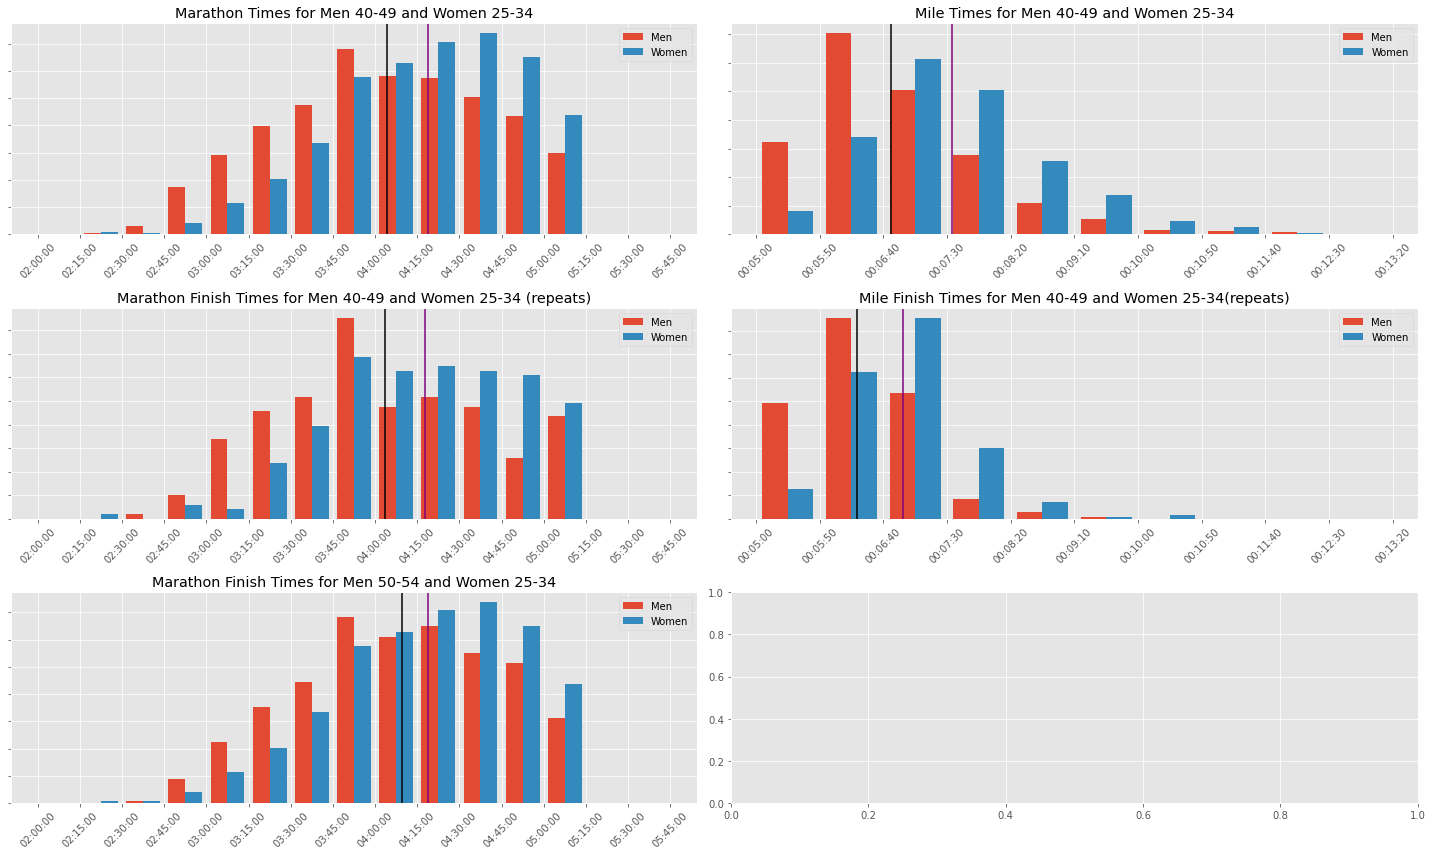

In [185]:
def plot(data, titles, labels, x_range, bins):
    fig, axes = plt.subplots(3,2, figsize = (20, 12))
    for i, ax in enumerate(axes.flat):
        ax.hist(data[i][1:], bins = bins[i], density = True, align = ('mid'), label = ['Men', 'Women'])
        ax.spines["bottom"].set_visible(True)      
        ax.spines["left"].set_visible(True)
        ax.axvline(data[i][1].mean(), color = 'black')
        ax.axvline(data[i][2].mean(), color = 'purple')
        ax.set_title(titles[i])
        ax.set_yticklabels([])
        ax.set_xticklabels(labels[i], rotation = '45')
        ax.set_xticks(bins[i])
        ax.legend()
        if i == 4:
            break
    fig.tight_layout()

plot(data, titles, x_axis_labels, mar_x_range, bins)

In [ ]:
def plot(data, titles, labels, x_range, bins):
    fig, axes = plt.subplots(3,2, figsize = (20, 12))
    for i, ax in enumerate(axes.flat):
        ax.hist(data[i], bins = bins[i], density = True, align = ('mid'), label = ['Men', 'Women'])
        ax.spines["bottom"].set_visible(True)      
        ax.spines["left"].set_visible(True)
        ax.axvline(data[i][0].mean(), color = 'black')
        ax.axvline(data[i][1].mean(), color = 'purple')
        ax.set_title(titles[i])
        ax.set_yticklabels([])
        ax.set_xticklabels(labels[i], rotation = '45')
        ax.set_xticks(bins[i])
        ax.legend()
        if i == 4:
            break
    fig.tight_layout()

plot(data, titles, x_axis_labels, mar_x_range, bins)

In [195]:
men_mean = round(quant_list[0]['Time(sec)'].mean())
men_std = round(quant_list[0]['Time(sec)'].std())

women_mean = round(quant_list[1]['Time(sec)'].mean())
women_std = round(quant_list[1]['Time(sec)'].std())

#print(stats.shapiro(quant_list[0]['Time(sec)']))

def calculate_t_test(sample1, sample2, type_I_error_rate):
    ttest = stats.ttest_ind(sample1, sample2, equal_var = False)
    return (ttest[1], ttest[1] < type_I_error_rate)

error = .05
print(calculate_t_test((quant_list[0])['Time(sec)'], (quant_list[1])['Time(sec)'], error/2))

for i in data:
    
print('''The mean of the men's times is {} with a standard deviation of {}. 
For the women, the mean is {} with a standard deviation of {}. 
Using a t-test with {} significance, we get a p-value of {} meaning that the null hypothesis is {}.'''.format(men_mean, men_std, women_mean, women_std, 1- error, results[0], results == False)) 

(6.172639721380716e-150, True)
The mean of the men's times is 15653 with a standard deviation of 3235. 
For the women, the mean is 16992 with a standard deviation of 3253. 
Using a t-test with 0.95 significance, we get a p-value of 6.172639721380716e-150 meaning that the null hypothesis is False.


14659 2222
15534 1953


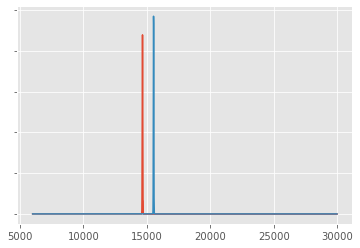

In [277]:
x = np.arange(6000, 30000, 10)
men = stats.norm(men_mean, men_std/np.sqrt(15000))
print(men_mean, men_std)
women = stats.norm(women_mean, women_std/np.sqrt(15000))
print(women_mean, women_std)

fig,ax = plt.subplots()
ax.plot(x, men.pdf(x))
ax.plot(x, women.pdf(x))
ax.set_yticklabels([])
statistic = men.ppf(.975)
ax.fill_between(x, men.pdf(x), where=(x >= statistic), color="red", alpha=0.5)

In [202]:
Null : performance is same
Alt: : performance is different

In order to determine that men perform differently than women, the mean of the women's group must have been greater than 21900.

SyntaxError: invalid syntax (<ipython-input-202-39f7527e8f6a>, line 2)

In [204]:
M_Mar['name'].str.title()

0        Abdi Abdirahman
1        Mustafa Mohamed
2         Fredison Costa
3       Vladimir Shatrov
4          Miguel Ferrer
              ...       
9696    Derrick Lawrence
9697         Paul Biguvu
9698    Joseph Frederick
9699        Steve Dubois
9700        Tane Walters
Name: name, Length: 9701, dtype: object

In [205]:
type(M_Mar['name'])

pandas.core.series.Series

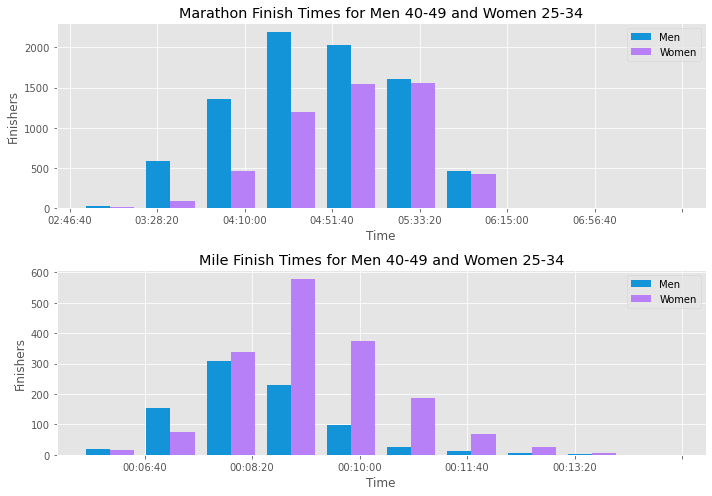

In [368]:
def sub_12(df):
    df_new = df[df['Time(sec)']<18864]
    return df_new['Time(sec)']

def sub_12_mile(df):
    df_new = df[df['Time(sec)']< 720]
    return df_new['Time(sec)']
sub_12_list = [sub_12(M_Mar), sub_12(W_Mar), sub_12_mile(M_Mile), sub_12_mile(W_Mile)]

plot_histograms(sub_12_list, formatTime(secs_mar), formatTime(secs_mile))


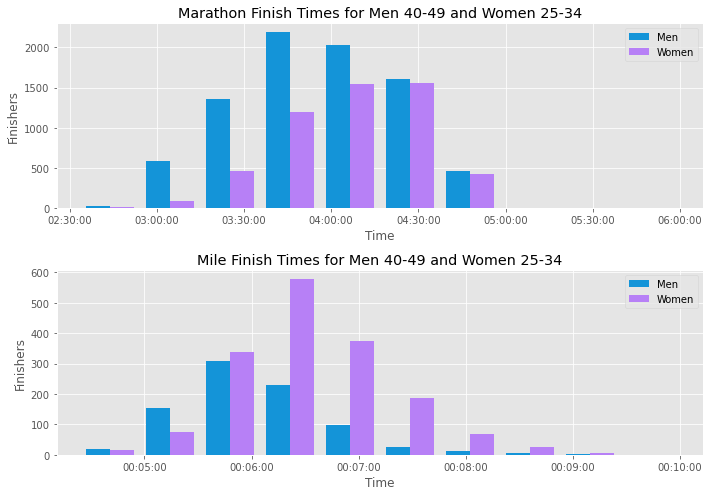

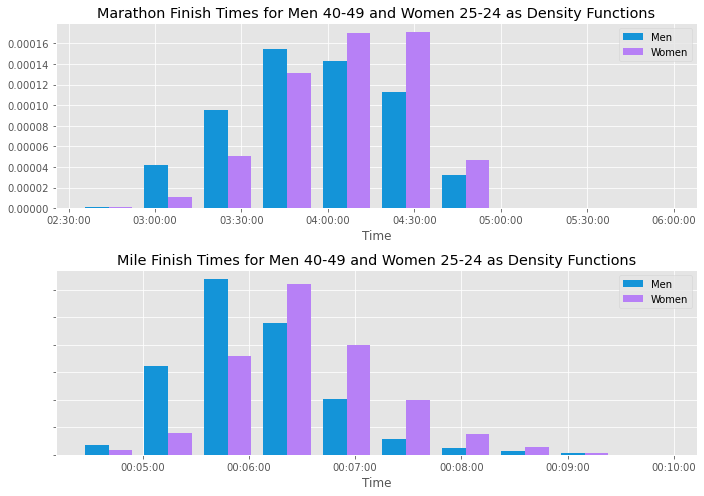

In [267]:
x = [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
twelve_sec = []
for i in x:
    twelve_sec.append(i*3600)

mar_x = format_time(twelve_sec)
mile_x = format_time([4*60, 5*60, 6*60, 7*60, 8*60, 9*60, 10*60, 11*60, 12*60])

plot_histograms(sub_12_list, mar_x, mile_x)
plot_histograms(sub_12_list, mar_x, mile_x, density = True)

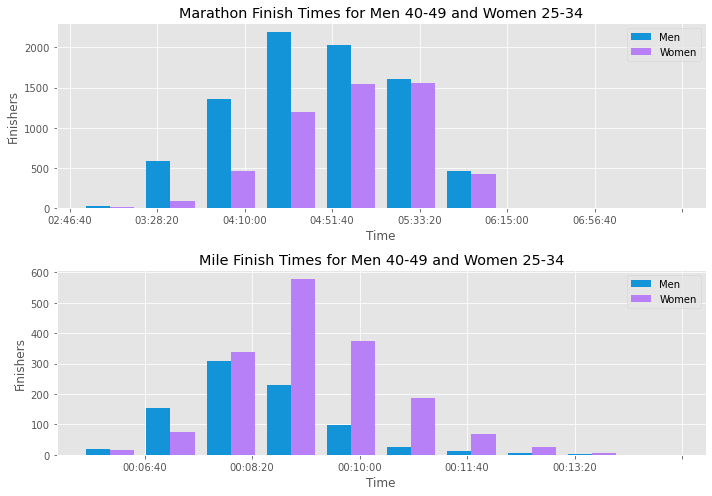

In [189]:
def calculate_t_test(data, type_I_error_rate):
    ttest = stats.ttest_ind(data[1], data[2], equal_var = False)
    print('Race: {}, p-value: {}'.format(data[0], ttest[1]))

error = .05

for i in data:
    calculate_t_test(i, error)
          
print('''The mean of the men's times is {} with a standard deviation of {}. 
For the women, the mean is {} with a standard deviation of {}. 
Using a t-test with {} significance, we get a p-value of {} meaning that the null hypothesis is {}.'''.format(men_mean, men_std, women_mean, women_std, 1- error, results[0], results == False)) 

Race: Mar, p-value: 6.989849401833806e-125
Race: Mile, p-value: 7.006868521433366e-54
Race: Mar_Repeats, p-value: 1.666429008612427e-05
Race: Mile_Repeats, p-value: 9.418413407414008e-15
Race: Mar_50, p-value: 4.761608526661595e-36


NameError: name 'men_mean' is not defined

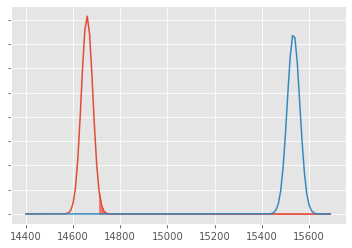

In [284]:
x = np.arange(14400, 15700, 10)
men = stats.norm(sub_12_list[0].mean(), sub_12_list[0].std()/np.sqrt(sub_12_list[0].count()))
women = stats.norm(sub_12_list[1].mean(), sub_12_list[1].std()/np.sqrt(sub_12_list[1].count()))

fig,ax = plt.subplots()
ax.plot(x, men.pdf(x))
ax.plot(x, women.pdf(x))
ax.set_yticklabels([])
statistic = men.ppf(.975)
ax.fill_between(x, men.pdf(x), where=(x >= statistic), color="red", alpha=0.5)

In [362]:
#df_repeats = M_Mar[M_Mar['name'] in ['Alexander Hoyt']]

df_repeats = M_Mar[M_Mar['name'].isin(list(M_Mile['name']))]

#df_new[df_new['l_ext'].isin([31, 22, 30, 25, 64])]

df_repeats.tail()

,_id,name,time,age,ag,dist,Time(sec),upper quartiles,sub12
9474,5f1711a9c94e506c54094885,Jose Flores,6:00:57,45,Men 45-49,Mar,21657,False,False
9499,5f1711a9c94e506c5409489e,Tony Vicente,6:05:36,46,Men 45-49,Mar,21936,False,False
9541,5f1711a9c94e506c540948c8,Kenneth Maser,6:15:34,47,Men 45-49,Mar,22534,False,False
9658,5f1711a9c94e506c5409493d,Kevin Chan,7:13:52,46,Men 45-49,Mar,26032,False,False
9689,5f1711aac94e506c5409495c,David Levenson,7:50:11,46,Men 45-49,Mar,28211,False,False


Text(0.5, 1.0, 'Normal Distribution of Mile Times for Men 40-49 and Women 25-34')

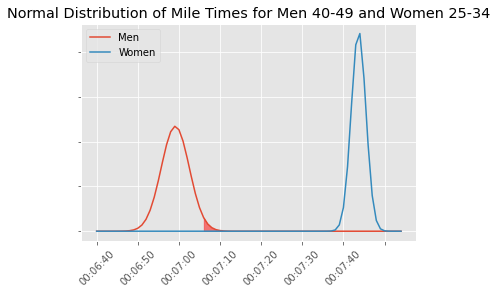

In [401]:
# Women vs Men 40-49 mile time
x = np.arange(390, 465, 1)
men = stats.norm(sub_12_list[2].mean(), sub_12_list[2].std()/np.sqrt(sub_12_list[2].count()))
women = stats.norm(sub_12_list[3].mean(), sub_12_list[3].std()/np.sqrt(sub_12_list[3].count()))

fig,ax = plt.subplots()
ax.plot(x, men.pdf(x), label = 'Men')
ax.plot(x, women.pdf(x), label = 'Women')
ax.set_yticklabels([])
ax.set_xticklabels(format_time([390+10*x for x in range(0, 8)]), rotation = "45")
statistic = men.ppf(.975)
ax.fill_between(x, men.pdf(x), where=(x >= statistic), color="red", alpha=0.5)
ax.legend()
ax.set_title("Normal Distribution of Mile Times for Men 40-49 and Women 25-34")

In [48]:
sm.stats.weightstats.CompareMeans.ztest_ind(M_Mar['Time(sec)'], W_Mar['Time(sec)'], usevar='unequal', value=0)


AttributeError: 'Series' object has no attribute 'd1'